In [1]:
import pandas as pd

df = pd.read_csv("/Users/my475/Downloads/archive (2)/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(df.head())
print(df.info())
print(df['Churn'].value_counts(normalize=True))


   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [4]:
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check how many nulls came from coercion
print(df['TotalCharges'].isnull().sum())

# Drop rows with null TotalCharges (optional, <1%)
df.dropna(subset=['TotalCharges'], inplace=True)


11


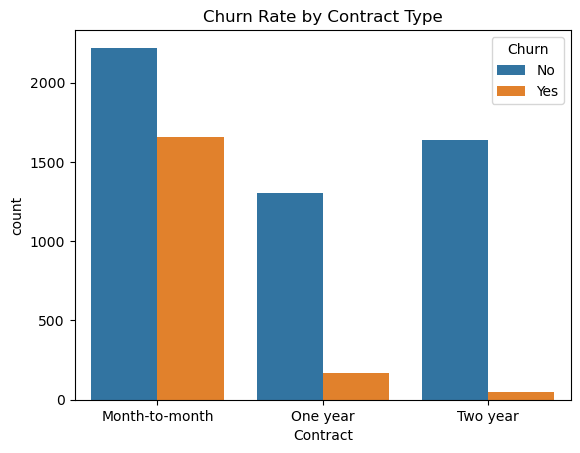

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Churn by Contract Type
sns.countplot(data=df, x='Contract', hue='Churn')
plt.title("Churn Rate by Contract Type")
plt.show()


In [7]:
df[['tenure', 'MonthlyCharges', 'TotalCharges']].corr()


,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.246862,0.825880
MonthlyCharges,0.246862,1.000000,0.651065
TotalCharges,0.825880,0.651065,1.000000


In [9]:
df_encoded = pd.get_dummies(df.drop('customerID', axis=1), drop_first=True)


In [10]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('Churn_Yes', axis=1)  # Target is 'Churn_Yes'
y = df_encoded['Churn_Yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.83      0.90      0.86      1033
        True       0.63      0.48      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407



In [13]:
model = RandomForestClassifier(class_weight='balanced', random_state=42)


In [14]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)


In [15]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_sm, y_train_sm)
y_pred_xgb = xgb.predict(X_test)

print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

       False       0.85      0.83      0.84      1033
        True       0.56      0.58      0.57       374

    accuracy                           0.77      1407
   macro avg       0.70      0.71      0.71      1407
weighted avg       0.77      0.77      0.77      1407



C:\Users\my475\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:57:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


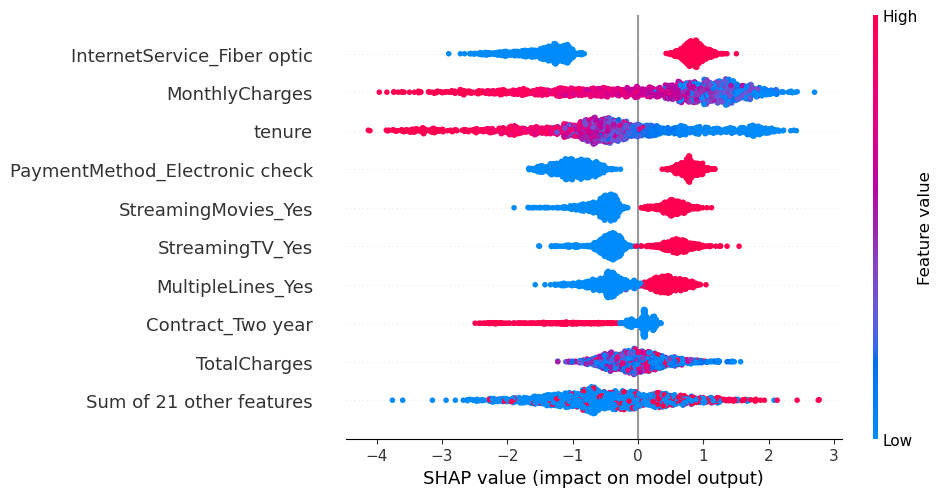

In [16]:
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)
